In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.12MB/s]


In [3]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
def one_hot_encode(labels, num_classes=10):
    """Converts integer labels (N,) to one-hot vectors (N, 10)."""
    return np.eye(num_classes)[labels]

In [5]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu'):
        """
        layer_sizes: List of integers [input_size, hidden1, hidden2, ..., output_size]
        activation: 'relu', 'sigmoid', or 'tanh' (for hidden layers)
        """
        self.layer_sizes = layer_sizes
        self.activation_choice = activation
        self.params = {}
        self.cache = {}

        np.random.seed(42)
        for i in range(1, len(layer_sizes)):
            n_in = layer_sizes[i-1]
            n_out = layer_sizes[i]

            if activation == 'relu':
                scale = np.sqrt(2.0 / n_in)
            else:
                scale = np.sqrt(1.0 / n_in)

            self.params[f'W{i}'] = np.random.randn(n_in, n_out) * scale
            self.params[f'b{i}'] = np.zeros((1, n_out))

    def _activation(self, Z, name):
        if name == 'relu':
            return np.maximum(0, Z)
        elif name == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif name == 'tanh':
            return np.tanh(Z)
        elif name == 'softmax':
            exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
            return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def _activation_derivative(self, Z, name):
        if name == 'relu':
            return (Z > 0).astype(float)
        elif name == 'sigmoid':
            s = 1 / (1 + np.exp(-Z))
            return s * (1 - s)
        elif name == 'tanh':
            return 1 - np.tanh(Z)**2
        return 1  # Linear/Identity

    # Forward Propagation
    def forward(self, X):
        self.cache['A0'] = X
        L = len(self.layer_sizes) - 1

        for i in range(1, L):
            Z = np.dot(self.cache[f'A{i-1}'], self.params[f'W{i}']) + self.params[f'b{i}']
            A = self._activation(Z, self.activation_choice)
            self.cache[f'Z{i}'] = Z
            self.cache[f'A{i}'] = A

        Z_out = np.dot(self.cache[f'A{L-1}'], self.params[f'W{L}']) + self.params[f'b{L}']
        A_out = self._activation(Z_out, 'softmax')
        self.cache[f'Z{L}'] = Z_out
        self.cache[f'A{L}'] = A_out

        return A_out

    # Loss Calculation
    def compute_loss(self, Y_true, Y_pred):
        m = Y_true.shape[0]
        Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
        loss = -np.sum(Y_true * np.log(Y_pred)) / m
        return loss

    # Backward Propagation
    def backward(self, Y_true, Y_pred):
        m = Y_true.shape[0]
        self.grads = {}
        L = len(self.layer_sizes) - 1

        dZ = Y_pred - Y_true

        self.grads[f'dW{L}'] = np.dot(self.cache[f'A{L-1}'].T, dZ) / m
        self.grads[f'db{L}'] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(L-1, 0, -1):
            dA = np.dot(dZ, self.params[f'W{i+1}'].T)
            dZ = dA * self._activation_derivative(self.cache[f'Z{i}'], self.activation_choice)

            self.grads[f'dW{i}'] = np.dot(self.cache[f'A{i-1}'].T, dZ) / m
            self.grads[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True) / m

    def update_parameters(self, learning_rate):
        L = len(self.layer_sizes) - 1
        for i in range(1, L + 1):
            self.params[f'W{i}'] -= learning_rate * self.grads[f'dW{i}']
            self.params[f'b{i}'] -= learning_rate * self.grads[f'db{i}']

    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)

    def evaluate(self, data_loader):
        total_loss = 0
        correct = 0
        samples = 0

        for images, labels in data_loader:
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()

            X = images.reshape(images.shape[0], -1)
            Y_true = one_hot_encode(labels)

            Y_pred = self.forward(X)

            total_loss += self.compute_loss(Y_true, Y_pred) * len(labels)
            preds = np.argmax(Y_pred, axis=1)
            correct += np.sum(preds == labels)
            samples += len(labels)

        return total_loss / samples, correct / samples

In [6]:
def run_experiment(model, epochs=5, learning_rate=0.1):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"Training Model: {model.activation_choice}, Layers: {model.layer_sizes}")

    for epoch in range(epochs):
        batch_losses = []
        batch_accs = []

        for images, labels in train_loader:
            images = images.cpu()
            labels = labels.cpu()
            images_np = images.numpy()
            labels_np = labels.numpy()

            # Flatten images
            X = images_np.reshape(images_np.shape[0], -1)
            Y = one_hot_encode(labels_np)

            Y_pred = model.forward(X)

            loss = model.compute_loss(Y, Y_pred)
            model.backward(Y, Y_pred)

            model.update_parameters(learning_rate)

            batch_losses.append(loss)
            preds = np.argmax(Y_pred, axis=1)
            batch_accs.append(np.mean(preds == labels_np))

        val_loss, val_acc = model.evaluate(val_loader)
        train_loss = np.mean(batch_losses)
        train_acc = np.mean(batch_accs)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    return history

In [7]:
experiments = {}

model_relu = NeuralNetwork([784, 128, 64, 10], activation='relu')
experiments['ReLU'] = run_experiment(model_relu, epochs=5, learning_rate=0.1)

model_sig = NeuralNetwork([784, 128, 64, 10], activation='sigmoid')
experiments['Sigmoid'] = run_experiment(model_sig, epochs=5, learning_rate=0.1)

model_tanh = NeuralNetwork([784, 128, 64, 10], activation='tanh')
experiments['Tanh'] = run_experiment(model_tanh, epochs=5, learning_rate=0.1)

model_deep = NeuralNetwork([784, 256, 128, 64, 10], activation='relu')
experiments['Deep ReLU'] = run_experiment(model_deep, epochs=5, learning_rate=0.05)

Training Model: relu, Layers: [784, 128, 64, 10]
Epoch 1/5 | Train Loss: 0.3302 Acc: 0.9024 | Val Loss: 0.2080 Acc: 0.9364
Epoch 2/5 | Train Loss: 0.1482 Acc: 0.9555 | Val Loss: 0.1252 Acc: 0.9607
Epoch 3/5 | Train Loss: 0.1075 Acc: 0.9686 | Val Loss: 0.1056 Acc: 0.9682
Epoch 4/5 | Train Loss: 0.0845 Acc: 0.9748 | Val Loss: 0.1139 Acc: 0.9655
Epoch 5/5 | Train Loss: 0.0694 Acc: 0.9794 | Val Loss: 0.0851 Acc: 0.9729
Training Model: sigmoid, Layers: [784, 128, 64, 10]
Epoch 1/5 | Train Loss: 1.4822 Acc: 0.5713 | Val Loss: 0.6667 Acc: 0.8219
Epoch 2/5 | Train Loss: 0.5169 Acc: 0.8579 | Val Loss: 0.4150 Acc: 0.8840
Epoch 3/5 | Train Loss: 0.3838 Acc: 0.8921 | Val Loss: 0.3512 Acc: 0.8987
Epoch 4/5 | Train Loss: 0.3314 Acc: 0.9046 | Val Loss: 0.3078 Acc: 0.9089
Epoch 5/5 | Train Loss: 0.2996 Acc: 0.9136 | Val Loss: 0.2824 Acc: 0.9194
Training Model: tanh, Layers: [784, 128, 64, 10]
Epoch 1/5 | Train Loss: 0.3862 Acc: 0.8940 | Val Loss: 0.2416 Acc: 0.9283
Epoch 2/5 | Train Loss: 0.2086 Acc: 

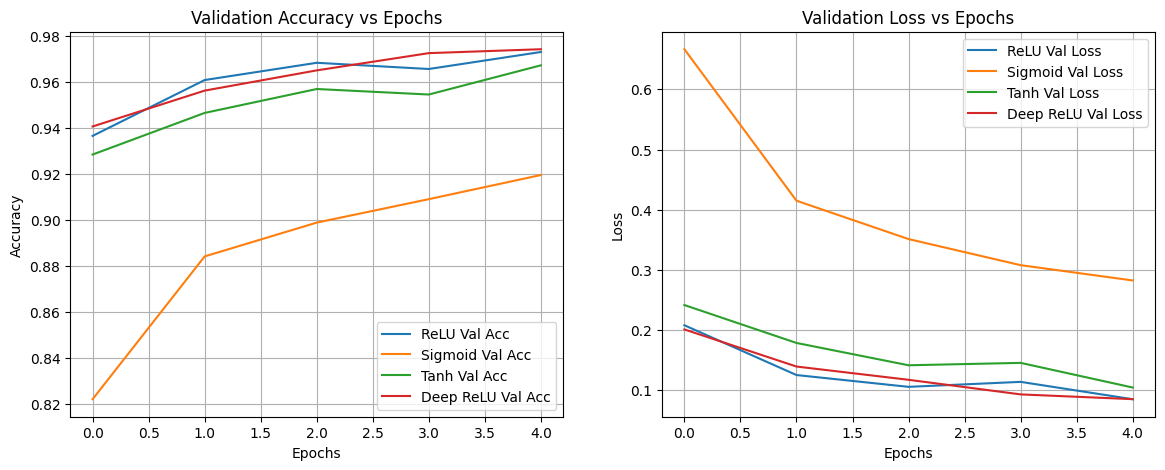

In [8]:
# Plotting Results
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
for name, hist in experiments.items():
    plt.plot(hist['val_acc'], label=f'{name} Val Acc')
plt.title('Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
for name, hist in experiments.items():
    plt.plot(hist['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()